In [33]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import random
from sklearn import feature_extraction
from nltk.corpus.reader import CategorizedPlaintextCorpusReader

### Stopwords, stemming, and tokenizing

In [34]:
corpus = CategorizedPlaintextCorpusReader("./corpus/lyrics/tokenized/", r".*\.txt", cat_pattern=r"(\w+)/*")

In [35]:
total_tracks_to_cluster = 50

In [36]:
tracks_all = []
for x in range(0, len(corpus.fileids())):
    tracks_all.append(corpus.raw(corpus.fileids()[x]))

In [37]:
len(tracks_all)
track_idx = random.sample(xrange(len(tracks_all)), total_tracks_to_cluster)

In [38]:
tracks = []
for i in range(0,len(track_idx)):
    tracks.append(tracks_all[track_idx[i]])

In [39]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []
for i in range(0,len(tracks)):
    ranks.append(i)

In [40]:
track_names = []
for i in range(0,len(track_idx)):
    track_names.append(corpus.fileids()[track_idx[i]])
track_names[:5]

['7CbtzSjCBFm4LdFGgnE6ge.txt.txt',
 '1aDzvUL7spSjeDpGtCMoGu.txt.txt',
 '0Avmi9t3sOcaGSs1DSbgDg.txt.txt',
 '4QfcqFDd5qQDK3YOZ0Ia8K.txt.txt',
 '6YQkya82b7rjiho4cFbS8k.txt.txt']

In [41]:
stopwords = nltk.corpus.stopwords.words('english')

In [42]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [43]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [44]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for track in tracks:
    allwords_stemmed = tokenize_and_stem(track)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(track)
    totalvocab_tokenized.extend(allwords_tokenized)

In [45]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head()

,words
beauti,beautiful
thought,thought
think,thinking
concern,concerning
great,great


### Tf-idf and document similarity

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tracks)

print(tfidf_matrix.shape)

CPU times: user 279 ms, sys: 14.3 ms, total: 293 ms
Wall time: 296 ms
(50, 27)


In [47]:
terms = tfidf_vectorizer.get_feature_names()

In [48]:
terms[:10]

[u'alon',
 u'away',
 u'blue',
 u'come',
 u'cri',
 u'day',
 u'eye',
 u'good',
 u'got',
 u'heart']

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

In [50]:
from sklearn.cluster import KMeans

num_clusters = 4
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 85.9 ms, sys: 4.33 ms, total: 90.3 ms
Wall time: 110 ms


In [51]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [52]:
import pandas as pd

tracks = { 'title': track_names, 'rank': ranks, 'track': tracks, 'cluster': clusters }
frame = pd.DataFrame(tracks, index = [clusters],
                     columns = ['rank', 'title', 'cluster'])
frame.head()

,rank,title,cluster
0,0,7CbtzSjCBFm4LdFGgnE6ge.txt.txt,0
2,1,1aDzvUL7spSjeDpGtCMoGu.txt.txt,2
0,2,0Avmi9t3sOcaGSs1DSbgDg.txt.txt,0
2,3,4QfcqFDd5qQDK3YOZ0Ia8K.txt.txt,2
0,4,6YQkya82b7rjiho4cFbS8k.txt.txt,0


In [53]:
# This is the count of songs per cluster
frame['cluster'].value_counts()

2    18
3    13
0    12
1     7
Name: cluster, dtype: int64

In [54]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

cluster
0    21.416667
1    27.714286
2    25.000000
3    24.923077
Name: rank, dtype: float64

In [55]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    # uncomment for labels
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: know, tell, man, heart, away, want,
Cluster 0 titles: 7CbtzSjCBFm4LdFGgnE6ge.txt.txt, 0Avmi9t3sOcaGSs1DSbgDg.txt.txt, 6YQkya82b7rjiho4cFbS8k.txt.txt, 77v6sQU1cByaXJsX0t3yjG.txt.txt, 5J65xr8NkvpHy9RkxzSUAO.txt.txt, 5WPUS2sEa1ZMQWjSAsGERs.txt.txt, 1Dp9VyBsH3KDRk1LbaL0gs.txt.txt, 76VZYZ3LsrS4fKYEMSYPXw.txt.txt, 036B7lKiRkLerLGI6EHtEr.txt.txt, 3ty6IIfuP0fXZ1XZDqQXmf.txt.txt, 3A3kg1SK2gpHNPZJmXpfTv.txt.txt, 0doe6BX5PtV8BDH0IffSdQ.txt.txt,

Cluster 1 words: love, heart, time, coming, alone, makes,
Cluster 1 titles: 2XnijEio1FOITUTzbwFpBM.txt.txt, 10QGw1IQGLaslKp5liNkNL.txt.txt, 19uCyfUQnRgOAXVUAczJYe.txt.txt, 6aBUYjmcolzTWtssjzryAP.txt.txt, 2RKAz2YBhNAkCSJjGAUrFd.txt.txt, 5yrEDH9bh0UgOoCwS7NmKZ.txt.txt, 7eD67wTnw9rCvwtkvaTS3M.txt.txt,

Cluster 2 words: got, time, makes, day, coming, blue,
Cluster 2 titles: 1aDzvUL7spSjeDpGtCMoGu.txt.txt, 4QfcqFDd5qQDK3YOZ0Ia8K.txt.txt, 0KSHmjK7OFtGocvbo7NZNO.txt.txt, 0FR4Ua3VxoSVA7DOFtdPlO.txt.txt, 4XJBLAzMOJs2z8ZuU58

### Multidimensional scaling

In [56]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS # this is a way of reducing dimensions to plottable 2. TSNE is another.

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [57]:
%matplotlib inline

### Visualizing document clusters

In [58]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: 'steelblue'}

#set up cluster names using a dict
cluster_names = {0: 'bitch, nigga, money, fuck, shit, know', 
                 1: 'nigga, shit, fuck, bitch, know, cause', 
                 2: 'know, time, let, make, cause, life', 
                 3: 'na, wan, wan, gon, gon, baby', 
                 4: 'girls, know, baby, let, want, coming',
                 5: 'love, know, time, baby, think, coming'}

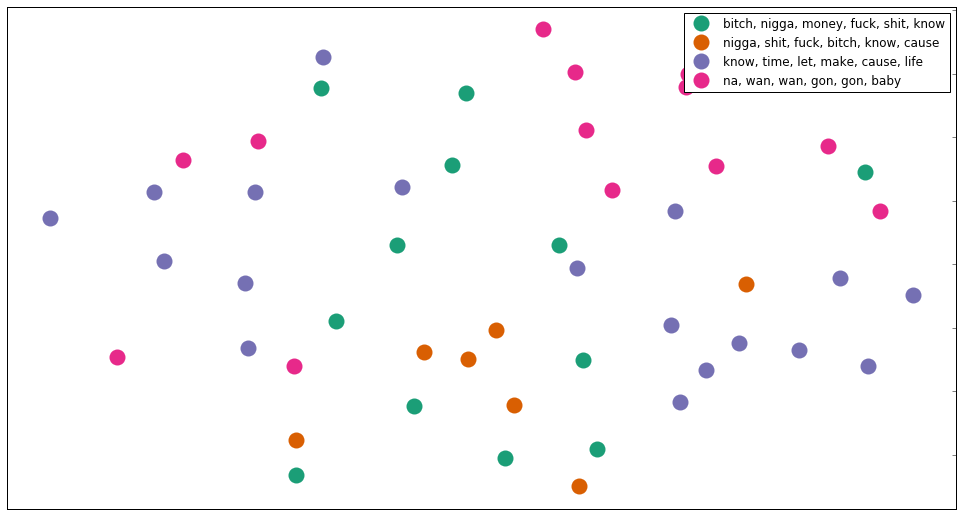

In [59]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=track_names)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=16, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('./plots/clusters_small_noaxes.png', dpi=200)